In [29]:
import hashlib
import os
import tarfile
import zipfile
import requests

In [30]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [31]:
train_data = pd.read_csv('.\\data\\HousePriceAdvance\\train.csv')
test_data = pd.read_csv('.\\data\\HousePriceAdvance\\test.csv')

In [32]:
# train_data.shape
print(train_data.shape)
print(test_data.shape)
# train_data['Id']
# test_data
train_data

(1460, 81)
(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [33]:
#前四个和最后两个特征，以及相应标签（房价）
print(train_data.iloc[0:4,[0,1,2,3,-3,-2,-1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [34]:
#在每个样本中，第一个特征是ID，我们将其中数据集中删除
all_features = pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:]))

In [35]:
#将所有缺失的值替换为相应特征的平均值。通过将特征重新缩放到零均值和单位方差来标准化数据

# 找出所有数字
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index

# 归一化
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std())
)

all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [36]:
#处理离散值。我们用一次独热编码替换它们

# 独热编码
all_features = pd.get_dummies(all_features,dummy_na=True)

all_features
# all_features.shape

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0.067320,-0.184443,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.523038,0.580708,-0.29303,...,False,True,False,False,False,False,False,True,False,False
1,-0.873466,0.458096,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.569893,1.177709,-0.29303,...,False,True,False,False,False,False,False,True,False,False
2,0.067320,-0.055935,0.137173,0.646073,-0.507197,0.980053,0.848819,0.333448,0.097840,-0.29303,...,False,True,False,False,False,False,False,True,False,False
3,0.302516,-0.398622,-0.078371,0.646073,-0.507197,-1.859033,-0.682695,-0.569893,-0.494771,-0.29303,...,False,True,False,True,False,False,False,False,False,False
4,0.067320,0.629439,0.518814,1.355319,-0.507197,0.947040,0.753100,1.381770,0.468770,-0.29303,...,False,True,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.419286,-2.069222,-1.043758,-1.481667,1.289537,-0.043338,-0.682695,-0.569893,-0.968860,-0.29303,...,False,True,False,False,False,False,False,True,False,False
1455,2.419286,-2.069222,-1.049083,-1.481667,-0.507197,-0.043338,-0.682695,-0.569893,-0.415757,-0.29303,...,False,True,False,True,False,False,False,False,False,False
1456,-0.873466,3.884968,1.246594,-0.772420,1.289537,-0.373465,0.561660,-0.569893,1.717643,-0.29303,...,False,True,False,True,False,False,False,False,False,False
1457,0.655311,-0.312950,0.034599,-0.772420,-0.507197,0.682939,0.370221,-0.569893,-0.229194,-0.29303,...,False,True,False,False,False,False,False,True,False,False


In [37]:
#从pandas格式中提取NumPy格式，并将其转换为张量表示

# 显式格式转换，不然object类型无法转为tensor
all_features = all_features.astype(float)

# 取出训练集features和labels
n_train = train_data.shape[0]
train_features = torch.tensor(
    all_features[:n_train].values, dtype=torch.float32
)

train_labels = torch.tensor(
    train_data['SalePrice'].values.reshape(-1, 1), dtype=torch.float32
)

# 取出测试集
test_features = torch.tensor(
    all_features[n_train:].values, dtype=torch.float32
)


In [38]:
#训练
# loss = nn.MSELoss(reduction='none')
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

In [39]:
#我们更关心相对误差，解决这个问题的一种方法是用价格预测的对数来衡量差异

#  对数均方根误差
def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

In [40]:
#我们的训练函数将借助Adam优化器，Adam对学习率没有那么敏感，学习率使用范围会宽一点

# Adam自适应矩估计 (动量，防止进入局部最小值和鞍点)
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []

    # train_features 和 train_labels 是tensor类型
    train_iter = d2l.load_array((train_features, train_labels), batch_size)



    # dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    # train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)


    # 用于梯度下降
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [41]:
#K折交叉验证

# 第 i 折作为验证集
def get_k_fold_data(k, i, X, y):

    # 为假就抛出异常
    assert k > 1

    # 每折大小
    fold_size = X.shape[0] // k

    # 存 k-1 个训练集
    X_train, y_train = None, None

    for j in range(k):

        # 存每个折的切片
        idx = slice(j * fold_size, (j + 1) * fold_size)

        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part

            # 直接用 None 合并会报错
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [42]:
#返回训练和验证误差的平均值

def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold{i + 1}，train log rmse{float(train_ls[-1]):f}, '
              f'vaild log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

fold1，train log rmse0.169677, vaild log rmse0.156418
fold2，train log rmse0.162412, vaild log rmse0.190073
fold3，train log rmse0.163656, vaild log rmse0.168248
fold4，train log rmse0.167691, vaild log rmse0.154427
fold5，train log rmse0.162346, vaild log rmse0.182352
5-折验证: 平均训练log rmse: 0.165156, 平均验证log rmse: 0.170304


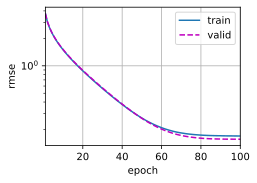

In [43]:
#模型选择
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

训练log rmse：0.162351


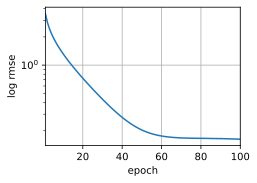

In [44]:
#提交你的Kaggle预测

# 保存结果
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')

    preds = net(test_features).detach().numpy()
    
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)
    
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)